# Introduction to Data Science
## Homework 4 

Student Name: Yueqiu Sun

Student Netid: ys3202
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [13]:
import numpy as np
from string import punctuation
import os
import pandas as pd
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn import preprocessing

In [4]:
def cleanBosonData(infile_name):
    cwd=os.getcwd()
    string='/'.join(cwd.split('/'))+'/'+infile_name
    df = pd.read_csv(string,index_col='EventId')
    le = preprocessing.LabelEncoder()
    le.fit(df["Label"])
    df["Y"]=le.transform(df["Label"])
    df["Label"].value_counts()
    df = df.drop("Label",1)
    mv_variable = ['Y']
    for variable in df.columns.values:
        if (df[variable].values==-999).any():
            var_name = variable+'_mv'
            mv_variable.append(var_name)
            df.loc[df[variable] == -999,var_name] = 1
            df[variable].replace(-999,(df.loc[df[variable]!=-999,variable].mean()), inplace=True)
        df_scaled=pd.DataFrame(preprocessing.scale(df.drop(mv_variable,1)),columns = df.drop(mv_variable,1).columns.values,index=df.index)
    data_clean=df_scaled
    df_scaled['Y'] = df.loc[:,'Y']
    return data_clean

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [5]:

data_train = cleanBosonData('boson_training_cut_2000.csv')
data_test = cleanBosonData('boson_testing_cut.csv')

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [6]:
X_train = data_train.drop('Y',1)
Y_train = data_train['Y']
X_test=data_test.drop('Y',1)
Y_test = data_test['Y']

In [7]:
#logistic regression
lr = LogisticRegression(C = 1e30)
lr.fit(X_train, Y_train)
preds_lr = lr.predict_proba(X_test)[:, 1]

In [8]:
#SVM
from sklearn.svm import SVC

clf=SVC(kernel="linear",probability=True)
clf.fit(X_train, Y_train)
preds_clf=clf.predict_proba(X_test)[:, 1]
#preds_clf[:100]

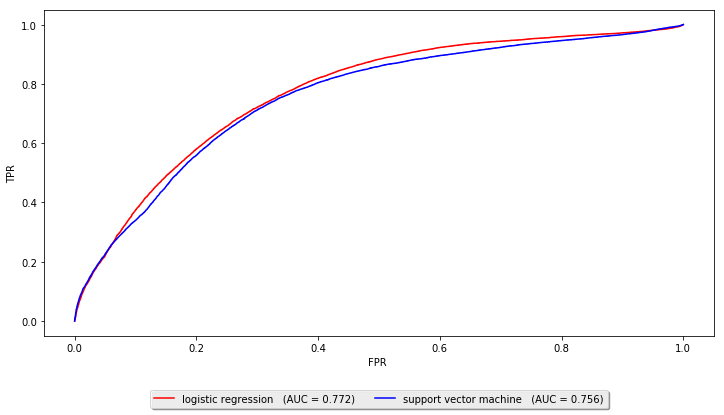

In [9]:
#plot the ROC curve of both models on the same plot
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_clf, tpr_clf, thresholds_clf = roc_curve(Y_test, preds_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(fpr_lr, tpr_lr, color = 'r', label = 'logistic regression  ' + ' (AUC = %0.3f)' % roc_auc_lr)
plt.plot(fpr_clf, tpr_clf, color = 'b', label = 'support vector machine  ' + ' (AUC = %0.3f)' % roc_auc_clf)

plt.xlabel('FPR ')
plt.ylabel('TPR')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

 From the graph we can see that the logistic regression is generally better at ranking the test set. The logistic regression would underperform the SVM given TPR is within the range of (0,0.25) and (0.95,1)


### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.cross_validation.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [14]:
from sklearn.cross_validation import KFold

def xValSVM(dataset, label_name, k, cs):
    dataset_X = dataset.drop(label_name,1)
    dataset_Y = dataset[label_name]

    kfolds = KFold(dataset.shape[0], n_folds = k)
    aucs={}
    for c in cs:
        aucs[c]=[]
    for train_index, test_index in kfolds:
        for c in cs:
            clf=SVC(C=c,kernel="linear",probability=True)
            clf.fit(dataset_X.iloc[train_index], dataset_Y.iloc[train_index])
            preds_clf=clf.predict_proba(dataset_X.iloc[test_index])[:, 1]
            fpr_clf, tpr_clf, thresholds_clf = roc_curve(dataset_Y.iloc[test_index], preds_clf)
            roc_auc_clf = auc(fpr_clf, tpr_clf)
            aucs[c].append(roc_auc_clf)

    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [15]:
cs=[10**i for i in range(-8,2)]
aucs = xValSVM(data_train, 'Y', 10, cs)

c having max(mean(AUC)) is 10 and the corrsponding AUC is 0.747549541586


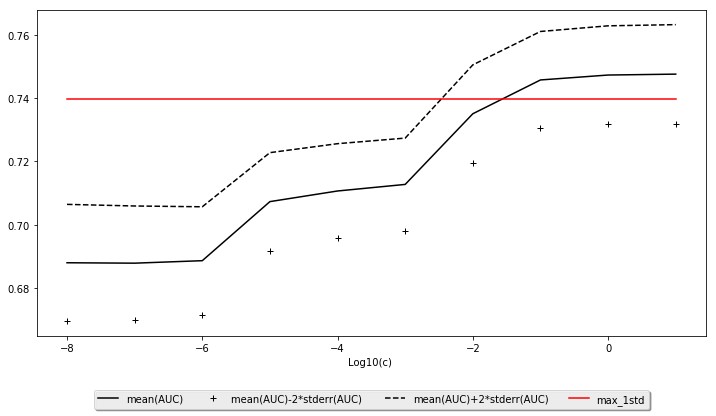

In [16]:
means=[]
stds=[]
max_1std=0
biggest_mean=0

for c in cs:
    mean=np.mean(aucs[c])
    std=np.sqrt(np.var(aucs[c])/len(aucs[c]))
    means.append(mean)
    stds.append(std)
    if(mean>biggest_mean):
        biggest_mean=mean
        max_1std=mean-std
        cmax=c

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(np.log10(cs), means,'k', label = 'mean(AUC)')
plt.plot(np.log10(cs), [means[i]-2*stds[i] for i in range(len(means))],'k+', label = 'mean(AUC)-2*stderr(AUC) ')
plt.plot(np.log10(cs), [means[i]+2*stds[i] for i in range(len(means))],'k--', label = 'mean(AUC)+2*stderr(AUC)')
plt.plot(np.log10(cs), np.repeat(max_1std,10),'r', label = 'max_1std')

plt.xlabel('Log10(c) ')
plt.ylabel('')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})
aucmax=np.mean(aucs[cmax])
print('c having max(mean(AUC)) is ' +str(cmax)+' and the corrsponding AUC is '+str(aucmax))

The out-of-the-box model for SVM produce AUC = 0.756, whereas the model using the selected model parameters gives us the AUC = 0.7475<0.756. There, the model parameters selected does not beat the out-of-the-box model for SVM.


### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [17]:
from sklearn.metrics import roc_auc_score
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    means=[]
    stds=[]
    for samplesize in sampsize:
        aucs=[]
        for i in range(nruns):
            train_sample=train.sample(n=samplesize,replace=True)
            train_X = train_sample.drop('Y',1)
            train_Y = train_sample['Y']
            test_X = test.drop('Y',1)
            test_Y = test['Y']
            if lr == 0:
                clf=SVC(C=c,kernel="linear",probability=True)
                clf.fit(train_X, train_Y)
                preds=clf.predict_proba(test_X)[:, 1]

            elif lr == 1:
                lrr = LogisticRegression()
                lrr.fit(train_X, train_Y)
                preds = lrr.predict_proba(test_X)[:, 1]

            fpr_clf, tpr_clf, thresholds_clf = roc_curve(test_Y, preds)
            roc_auc_clf = auc(fpr_clf, tpr_clf)
            aucs.append(roc_auc_clf)
        mean=np.mean(aucs)
        std=np.sqrt(np.var(aucs))
        means.append(mean)
        stds.append(std)
    return (means,stds)

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [18]:
#fit logistic model
train=data_train
test=data_test
nruns=20
sampsize = [50, 100, 200, 500, 1000, 1500, 2000]
c=10
(means_lr,stds_lr)=modBootstrapper(train, test, nruns, sampsize, 1, c)
(means_lr,stds_lr)

([0.71845965698610814,
  0.74182418857941401,
  0.74994932835180672,
  0.7631982547522933,
  0.76639812526044715,
  0.76923974718393462,
  0.77006731907389614],
 [0.046868969432891171,
  0.019173668089345283,
  0.010876001218000173,
  0.0053305572031495507,
  0.0037642854114283584,
  0.0016767279121564082,
  0.0015515151776414201])

In [19]:
#fit svm model
(means_clf,stds_clf)=modBootstrapper(train, test, nruns, sampsize, 0, c)
(means_clf,stds_clf)

([0.57323410509953443,
  0.70900341201092554,
  0.72765037023549484,
  0.73187413852178529,
  0.74813438282000455,
  0.7502578586553893,
  0.75171929626616818],
 [0.17612173089506067,
  0.037278908811723736,
  0.025255572983274278,
  0.020140280404106276,
  0.010431707592640008,
  0.0094301283158611231,
  0.011432477959614036])

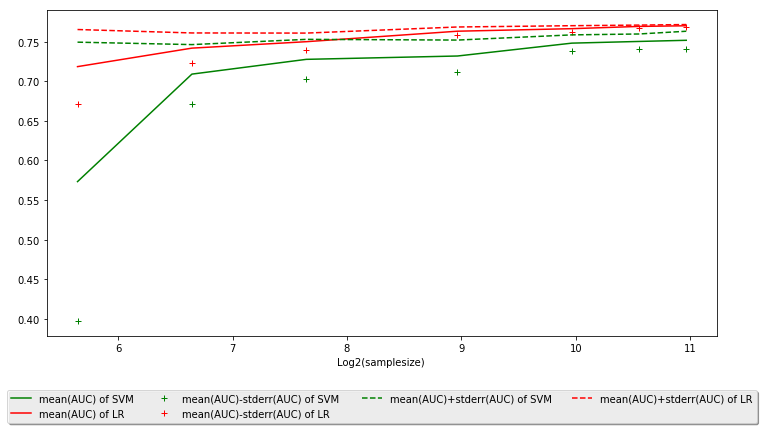

In [20]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(np.log2(sampsize), means_clf,'g', label = 'mean(AUC) of SVM')
plt.plot(np.log2(sampsize), means_lr,'r', label = 'mean(AUC) of LR')
plt.plot(np.log2(sampsize), [means_clf[i]-stds_clf[i] for i in range(len(means_clf))],'g+', label = 'mean(AUC)-stderr(AUC) of SVM ')
plt.plot(np.log2(sampsize), [means_lr[i]-stds_lr[i] for i in range(len(means_lr))],'r+', label = 'mean(AUC)-stderr(AUC) of LR ')
plt.plot(np.log2(sampsize), [means_clf[i]+stds_clf[i] for i in range(len(means_clf))],'g--', label = 'mean(AUC)+stderr(AUC) of SVM')
plt.plot(np.log2(sampsize), [means_lr[i]+stds_lr[i] for i in range(len(means_lr))],'r--', label = 'mean(AUC)+stderr(AUC) of LR')

plt.xlabel('Log2(samplesize) ')
plt.ylabel('')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})


3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


From the graph we can see that the the Logistic Regression is more suitable for smaller sample sizes because its AUC is larger given samplesize. 

We can see that by doubling the data, we can increase the AUC by approximately 1.5 using logistic regression if the data is small(less than 200). If the data is big, the increase will be less than 0.5. 

And by doubling the data, we can increase the AUC by approximately 2-4 using SVM if the data is small(less than 200). If the data is big, the increase will be less than 0.5. 

If the classifier aims to classify whether certain particle decay experiments identify the presence of a Higgs Boson, then the value of the increase in AUC is huge.

And if the increase in AUC will bring value that is larger than the cost, I think it is a worthy investment, especially when the data is small and doubling data will bring more increase in AUC.



4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



If the trainning samples are too small, the cross-validation might be biased and will result in a overestimate of prediction error.